In [19]:
import mat73 # for loading data files
import seaborn as sns # for plotting
import pandas as pd # for data manipulation
import numpy as np # for FFT
import matplotlib.pyplot as plt # for plotting
import tqdm # for progress bar

In [20]:
# Sample rate of the data
sample_rate = 48128

# Paths to the data files. Run download_data.py to download the data.
bg_data_path = "data/downloads/U09_Background.mat"
wt_data_path = "data/downloads/U09_Wind%20turbine.mat"

### >>> Prepare Data
Displays resulting dataframe with index corresponding to time in seconds and value corresponding to the mean of all mics for that time.

In [21]:
test = False # Set to True to run based on function, False to run based on data files

In [22]:
# >>>>>>>>> Run based on function
if test:
    def f(t):
        f_1 = 10
        f_2 = 500
        A_1 = 0.02 * np.sqrt(2)
        A_2 = 0.002 * np.sqrt(2)
        term_1 = A_1 * np.sin(2 * np.pi * f_1 * t + np.pi / 4)
        term_2 = A_2 * np.cos(2 * np.pi * f_2 * t + np.pi / 6)
        return term_1 + term_2

    # Create test data
    t = np.arange(0, 30, 1/sample_rate) # in seconds, from 0-30 with sample rate
    y = f(t)

    # Create dataframes, one with data and one with zeros
    df_wt_mean = pd.DataFrame(y)
    df_bg_mean = pd.DataFrame(np.zeros(y.shape)) # Ensure same shape as df_wt_mean

    # Rename cols
    df_bg_mean.columns = ["mean"]
    df_wt_mean.columns = ["mean"]

    # Create numpy array as input for np.fft
    np_bg_mean = df_bg_mean["mean"].values
    np_wt_mean = df_wt_mean["mean"].values

# We now have:
# df_bg_mean (dataframe, containing time data and mean of all mics for each time)
# df_wt_mean (dataframe, containing time data and mean of all mics for each time)

# >>>>>>>>> Run based on data files
else:
    # Extract data from mat file
    bg_data_dict = mat73.loadmat(bg_data_path)
    wt_data_dict = mat73.loadmat(wt_data_path)

    # Convert to dataframe
    df_bg = pd.DataFrame(bg_data_dict['Sig_Mic_bg'])
    df_wt = pd.DataFrame(wt_data_dict['Sig_Mic_rotating'])

    # Swap sample number for seconds
    df_bg.columns = df_bg.columns/sample_rate
    df_wt.columns = df_wt.columns/sample_rate

    # Get mean of each col with concat. Index is time in s, value is mean of all mics (rows)
    df_bg_mean = pd.concat([df_bg.mean(axis=0)], axis=1)
    df_wt_mean = pd.concat([df_wt.mean(axis=0)], axis=1)

    # Rename cols
    df_bg_mean.columns = ["mean"]
    df_wt_mean.columns = ["mean"]

    # Apply hamming window to data
    print("Applying hamming window...")
    for col in tqdm.tqdm(df_bg_mean.columns):
        df_bg_mean[col] = df_bg_mean[col] * np.hamming(df_bg_mean.shape[0])
    for col in tqdm.tqdm(df_wt_mean.columns):
        df_wt_mean[col] = df_wt_mean[col] * np.hamming(df_wt_mean.shape[0])

    # Create numpy array as input for np.fft
    np_bg_mean = df_bg_mean["mean"].values
    np_wt_mean = df_wt_mean["mean"].values

# We now have:
# df_bg_mean (dataframe, containing time data and mean of all mics for each time)
# df_wt_mean (dataframe, containing time data and mean of all mics for each time)
# np_bg_mean (numpy array, containing mean of all mics for each time)
# np_wt_mean (numpy array, containing mean of all mics for each time)


Applying hamming window...


100%|██████████| 1/1 [00:00<00:00, 31.21it/s]


### >>> Evaluate FFT

In [23]:
n_smoothing = 50 # Number of points to smooth FFT by

# Calculate the FFT
signal_fft_bg = np.fft.fft(np_bg_mean)
signal_fft_wt = np.fft.fft(np_wt_mean)

# Calculate the frequency axis - this creates an array of the same size as the signal with the frequency of each bin (in Hz).
ax_freq_bg = np.fft.fftfreq(np_bg_mean.size, d=1/sample_rate)
ax_freq_wt = np.fft.fftfreq(np_wt_mean.size, d=1/sample_rate)

# Create new dataframe for FFT results (absolute value, only positive frequencies)
df_bg_fft = pd.DataFrame({"freq": ax_freq_bg, "fft": signal_fft_bg})
df_bg_fft = df_bg_fft.loc[df_bg_fft["freq"] > 0]
df_wt_fft = pd.DataFrame({"freq": ax_freq_wt, "fft": signal_fft_wt})
df_wt_fft = df_wt_fft.loc[df_wt_fft["freq"] > 0]

# Smooth the FFT results - this is done by taking the mean of the n_smoothing values around each point.
#df_bg_fft["fft"] = df_bg_fft["fft"].rolling(n_smoothing).mean()
#df_wt_fft["fft"] = df_wt_fft["fft"].rolling(n_smoothing).mean()

# Denoise the WT signal - this is done by subtracting the BG FFT from the WT FFT.
df_wt_bg_fft = df_wt_fft.copy()
df_wt_bg_fft["fft"] = df_wt_bg_fft["fft"] - df_bg_fft["fft"]
df_wt_bg_fft.loc[df_wt_bg_fft["fft"] < 0, "fft"] = 0

# We now have:
# df_bg_fft (dataframe, containing frequency data and FFT of the background signal)
# df_wt_fft (dataframe, containing frequency data and FFT of the wind turbine signal)
# df_wt_bg_fft (dataframe, containing frequency data and FFT of the wind turbine signal, denoised by subtracting the background FFT)

### >>> Plot the FFT results

C:\Users\gones\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\gones\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\gones\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.0, 100.0)

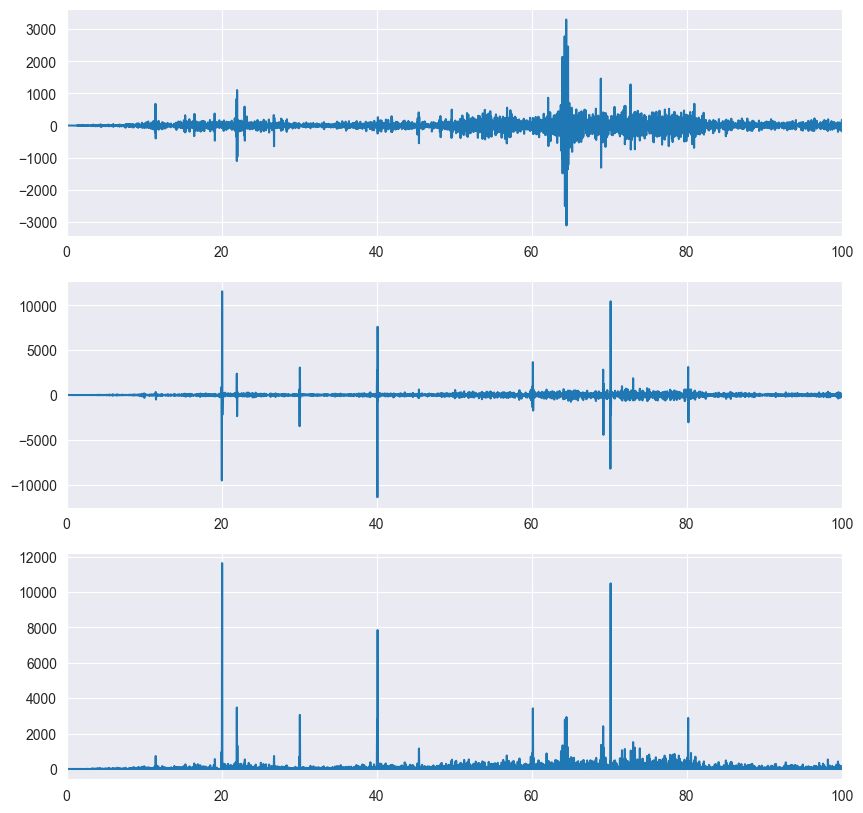

In [28]:
# Clear previous plots
plt.close("all")

x_lim_0 = 0
x_lim_1 = 100

# Create three subplots, with matplotlib
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

# Plot FFT results for background
ax[0].plot(df_bg_fft["freq"], df_bg_fft["fft"], label="Background")

# Plot FFT results for wind turbine
ax[1].plot(df_wt_fft["freq"], df_wt_fft["fft"], label="Wind Turbine")

# Plot FFT results for wind turbine, denoised by subtracting the background FFT
ax[2].plot(df_wt_bg_fft["freq"], df_wt_bg_fft["fft"], label="Wind Turbine - Background")

# Set x-axis limits
ax[0].set_xlim(x_lim_0, x_lim_1)
ax[1].set_xlim(x_lim_0, x_lim_1)
ax[2].set_xlim(x_lim_0, x_lim_1)

### >>> Re-evaluate FFT on 1/2s samples
Split df_bg and df_wt into 1/2s samples and apply FFT on each sample. Displays df_bg_fft.

In [25]:
n_smoothing = 1 # Number of points to smooth FFT by

# Iterate over every sample_rate/2 samples
df_bg_fft_t = pd.DataFrame()
df_wt_fft_t = pd.DataFrame()

for sample in range(0, len(df_bg_mean), int(sample_rate/2)):
    # Calculate the FFT
    signal_fft_bg = np.fft.fft(np_bg_mean[sample:sample+int(sample_rate/2)])
    signal_fft_wt = np.fft.fft(np_wt_mean[sample:sample+int(sample_rate/2)])

    # Calculate the frequency axis - this creates an array of the same size as the signal with the frequency of each bin (in Hz).
    ax_freq_bg = np.fft.fftfreq(np_bg_mean[sample:sample+int(sample_rate/2)].size, d=1/sample_rate)
    ax_freq_wt = np.fft.fftfreq(np_wt_mean[sample:sample+int(sample_rate/2)].size, d=1/sample_rate)

    # Create new dataframe for FFT results (absolute value, only positive frequencies)
    df_bg_fft_sample = pd.DataFrame({"freq": ax_freq_bg, "fft": np.abs(signal_fft_bg)})
    df_bg_fft_sample = df_bg_fft_sample.loc[df_bg_fft_sample["freq"] > 0]
    df_wt_fft_sample = pd.DataFrame({"freq": ax_freq_wt, "fft": np.abs(signal_fft_wt)})
    df_wt_fft_sample = df_wt_fft_sample.loc[df_wt_fft_sample["freq"] > 0]

    # Smooth the FFT results - this is done by taking the mean of the n_smoothing values around each point.
    df_bg_fft_sample["fft"] = df_bg_fft_sample["fft"].rolling(n_smoothing).mean()
    df_wt_fft_sample["fft"] = df_wt_fft_sample["fft"].rolling(n_smoothing).mean()

    # Add sample number to df
    df_bg_fft_sample["sample"] = sample
    df_wt_fft_sample["sample"] = sample

    # Append to df
    df_bg_fft_t = df_bg_fft_t.append(df_bg_fft_sample, ignore_index=True)
    df_wt_fft_t = df_wt_fft_t.append(df_wt_fft_sample, ignore_index=True)

# Denoise the WT signal - this is done by subtracting the BG FFT from the WT FFT.
df_wt_bg_fft_t = df_wt_fft_t.copy()
df_wt_bg_fft_t["fft"] = df_wt_bg_fft_t["fft"] - df_bg_fft_t["fft"]

df_bg_fft_t

# We now have:
# df_bg_fft_t: FFT results for background, for each 1/2s sample
# df_wt_fft_t: FFT results for wind turbine, for each 1/2s sample
# df_wt_bg_fft_t: FFT results for wind turbine, denoised by subtracting the background FFT

,freq,fft,sample
0,2.0,0.294491,0
1,4.0,0.381991,0
2,6.0,0.531628,0
3,8.0,1.433381,0
4,10.0,0.273926,0
...,...,...,...
721855,24054.0,0.000809,1419776
721856,24056.0,0.001560,1419776
721857,24058.0,0.000243,1419776
721858,24060.0,0.000320,1419776


### >>> Plot FFT results for 1/2s samples

(0.5, 5000.0)

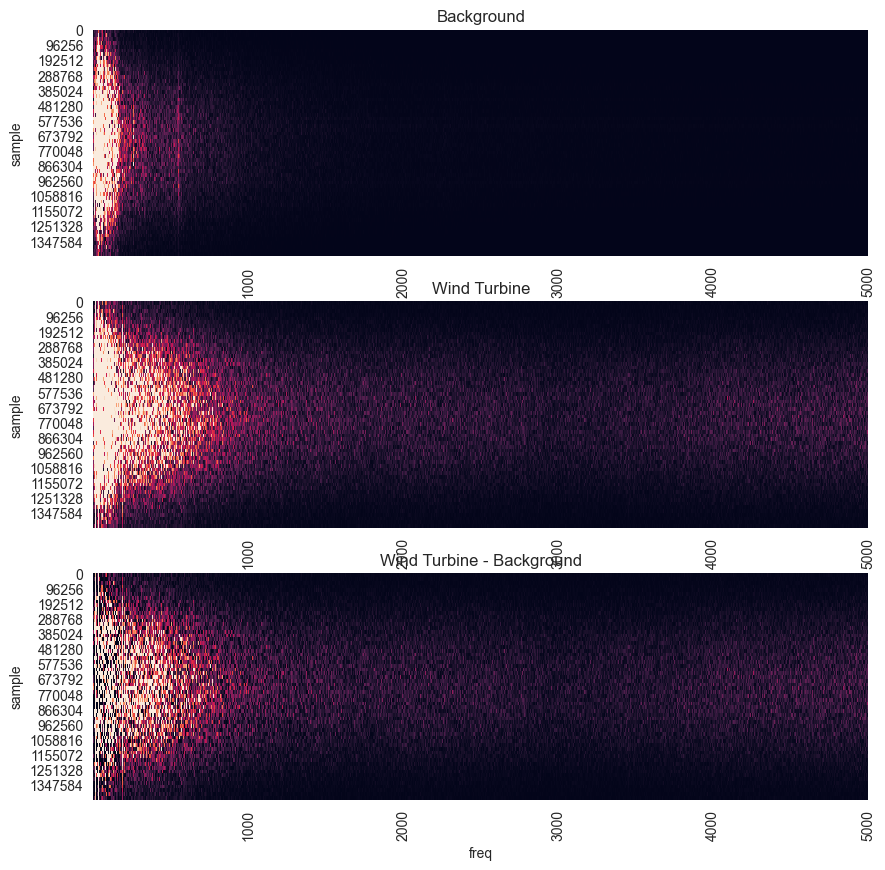

In [26]:
# Clear previous plots
plt.close("all")

vmin = 0
vmax = 10

x_lim_0 = 1
x_lim_1 = 10000

fig, ax = plt.subplots(3, 1, figsize=(10, 10))

# Plot three heatmaps with sns
sns.heatmap(df_bg_fft_t.pivot("sample", "freq", "fft"), ax=ax[0], cbar=False, vmin=vmin, vmax=vmax)
ax[0].set_title("Background")
ax[0].set_xscale("linear")
ax[0].set_xlim(x_lim_0/2, x_lim_1/2)

sns.heatmap(df_wt_fft_t.pivot("sample", "freq", "fft"), ax=ax[1], cbar=False, vmin=vmin, vmax=vmax)
ax[1].set_title("Wind Turbine")
ax[1].set_xscale("linear")
ax[1].set_xlim(x_lim_0/2, x_lim_1/2)

sns.heatmap(df_wt_bg_fft_t.pivot("sample", "freq", "fft"), ax=ax[2], cbar=False, vmin=vmin, vmax=vmax)
ax[2].set_title("Wind Turbine - Background")
ax[2].set_xscale("linear")
ax[2].set_xlim(x_lim_0/2, x_lim_1/2)


C:\Users\gones\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(0.5, 12500.0)

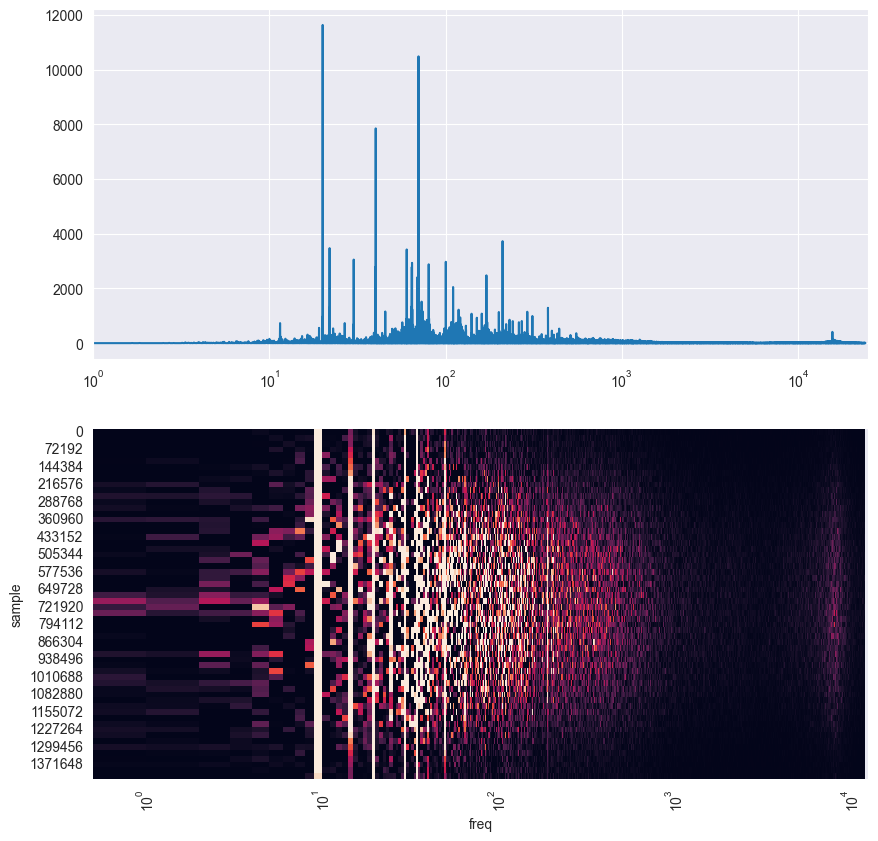

In [27]:
x_lim_0 = 1
x_lim_1 = 25000

# Plot heatmap of noise reduced WT signal, alongside FFT of noise reduced WT signal (time independent)
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

# Plot FFT
ax[0].plot(df_wt_bg_fft["freq"], df_wt_bg_fft["fft"], label="Wind Turbine - Background")
ax[0].set_xscale("log")
ax[0].set_xlim(x_lim_0, x_lim_1)

# Plot heatmap with x range
sns.heatmap(df_wt_bg_fft_t.pivot("sample", "freq", "fft"), ax=ax[1], cbar=False, vmin=0, vmax=30)
ax[1].set_xscale("log")
ax[1].set_xlim(x_lim_0/2, x_lim_1/2)
